In [1]:
!pip install torchinfo==1.7.0

### 1. Importing Libraries

In [4]:
import torch
print('PyTorch version:', torch.__version__)
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

import torchvision
print('Torchvision version:', torchvision.__version__)
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from tqdm import tqdm
from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt

# 2. Deine the device
print("GUP name:", torch.cuda.get_device_name(), '\n')
device = 'cuda' if torch.cuda.is_available() else 'cup'
print('Deice is:', device, '\n')
print('Total number of GPUs:', torch.cuda.device_count())

PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
GUP name: NVIDIA A100-SXM4-40GB 

Deice is: cuda 

Total number of GPUs: 1


###3. Load MNIST dataset

100%|██████████| 26.4M/26.4M [00:01<00:00, 16.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 271kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 4.99MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 17.6MB/s]


Class 0: T-shirt/top Class 1: Trouser Class 2: Pullover Class 3: Dress Class 4: Coat Class 5: Sandal Class 6: Shirt Class 7: Sneaker Class 8: Bag Class 9: Ankle boot 

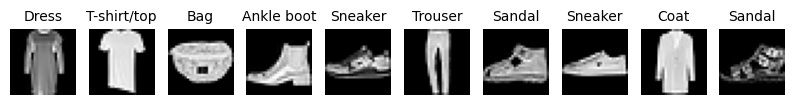

In [5]:
transform = transforms.Compose([transforms.Resize((32, 32)),transforms.ToTensor(),
                               transforms.Normalize(mean=(0.5,), std = (0.5,))])

training_dataset = datasets.FashionMNIST(root='./data_src', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data_src', train=False, download=True, transform=transform)


# show 10 randomly selected samples from the training dataset
classes = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Print the class labels
for idx, class_name in enumerate(classes):
    print(f"Class {idx}: {class_name}", end=" ")

fig, axis = plt.subplots(nrows=1, ncols=10, figsize=(10, 1))

for ax, _ in zip(axis.ravel(), range(10)):
  inx = np.random.randint(len(training_dataset))
  ax.imshow(training_dataset.data[inx], cmap='gray')
  ax.set_title(classes[int(training_dataset.targets[inx])], fontsize = 10)
  ax.axis(False);


4. Define dataloaders

In [6]:
training_dataloader = DataLoader(training_dataset, batch_size=64, shuffle=True, drop_last = True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)

### 5. Define Linear Variance Scheduler

In [7]:
class Linear_Variance_Scheduler:
    def __init__(self, time_steps, beta_start, beta_end, device='cuda'):

        self.time_steps = time_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.device = device

        self.betas = torch.linspace(self.beta_start, self.beta_end, self.time_steps).to(self.device)
        self.alphas = 1 - self.betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar)
        self.sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar)

    def diffusion_process(self, x, noise, t):
        sqrt_alpha_bar = self.sqrt_alpha_bar[t][:, None, None, None]
        sqrt_one_minus_alpha_bar = self.sqrt_one_minus_alpha_bar[t][:, None, None, None]
        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise

    def ddpm_sampling(self, model, num_samples, channels, img_size, labels): #
        model.eval()
        with torch.inference_mode():
            x = torch.randn((num_samples, channels, img_size, img_size)).to(self.device)
            collect = []
            for i in tqdm(reversed(range(self.time_steps))):
                t = (torch.ones(num_samples) * i).long().to(self.device)
                pred_noise = model(x, t, labels) #
                alphas = self.alphas[t][:, None, None, None]
                alpha_bar = self.alpha_bar[t][:, None, None, None]
                betas = self.betas[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alphas) * (x - ((1 - alphas) / (torch.sqrt(1 - alpha_bar))) * pred_noise) +\
                    torch.sqrt(betas) * noise
                if (i+1) % 100 == 0 or i==0:
                    collect.append(x)
        return x, collect

### 6. Forward Process Output

In [8]:
t_step = torch.linspace(start=0, end=1000-1, steps=11).long()
get_img = training_dataset[0][0]
print('Image label:', training_dataset[0][1])
get_img_stack = torch.stack([get_img]*11)
get_noise_stack = torch.randn_like(get_img_stack)

noisy_img_stack = Linear_Variance_Scheduler(time_steps=1000, beta_start=0.0001, beta_end=0.02,
                                            device='cpu').diffusion_process(get_img_stack, get_noise_stack, t_step)

Image label: 9


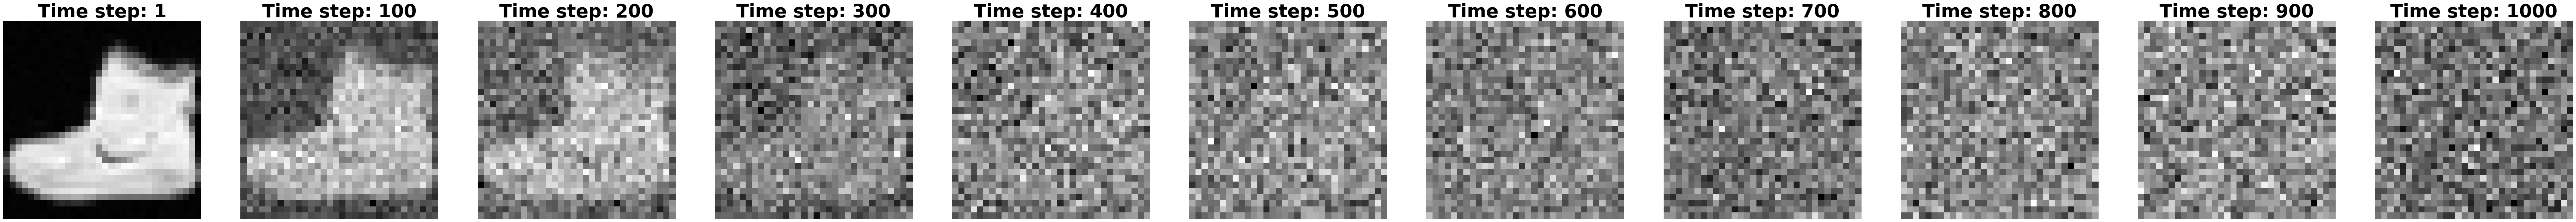

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=11, figsize=(100, 100))

for idx, img in enumerate(noisy_img_stack):
    ax[idx].imshow(img.squeeze(), cmap='gray')
    ax[idx].set_title(f'Time step: {t_step[idx]+1}', fontsize=40, fontweight='bold')
    ax[idx].axis(False);

### 7. Create ResBlock

In [10]:
class ResBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, mid_ch=None, residual=False):
        super(ResBlock, self).__init__()

        self.residual = residual
        if not mid_ch:
            mid_ch = out_ch
        self.resnet_conv = nn.Sequential()
        self.resnet_conv.add_module('conv1', nn.Conv2d(in_channels=inp_ch, out_channels=mid_ch, kernel_size=3, stride=1,
                                                       padding=1))
        self.resnet_conv.add_module('gnor1', nn.GroupNorm(num_groups=8, num_channels=mid_ch))
        self.resnet_conv.add_module('silu1', nn.SiLU())
        self.resnet_conv.add_module('conv2', nn.Conv2d(in_channels=mid_ch, out_channels=out_ch, kernel_size=3, stride=1,
                                                       padding=1))
        self.resnet_conv.add_module('gnor2', nn.GroupNorm(num_groups=8, num_channels=out_ch))

    def forward(self, x):
        if self.residual:
            return x + self.resnet_conv(x)
        else:
            return self.resnet_conv(x)

### 8. SelfAttentionBlock

In [11]:
class SelfAttentionBlock(nn.Module):
    def __init__(self, channels):
        super(SelfAttentionBlock, self).__init__()

        self.attn_norm = nn.GroupNorm(num_groups=8, num_channels=channels)
        self.mha = nn.MultiheadAttention(embed_dim=channels, num_heads=4, batch_first=True)

    def forward(self, x):
        b, c, h, w = x.shape
        inp_attn = x.reshape(b, c, h*w)
        inp_attn = self.attn_norm(inp_attn)
        inp_attn = inp_attn.transpose(1, 2)
        out_attn, _ = self.mha(inp_attn, inp_attn, inp_attn)
        out_attn = out_attn.transpose(1, 2).reshape(b, c, h, w)
        return x + out_attn

### 9. Create DownBlock

In [12]:
class DownBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, t_emb_dim=256):
        super(DownBlock, self).__init__()

        self.down = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResBlock(inp_ch=inp_ch, out_ch=inp_ch, residual=True),
            ResBlock(inp_ch=inp_ch, out_ch=out_ch)
        )

        self.t_emb_layers = nn.Sequential()
        self.t_emb_layers.add_module('silu1', nn.SiLU())
        self.t_emb_layers.add_module('linr1', nn.Linear(in_features=t_emb_dim, out_features=out_ch))

    def forward(self, x, t):
        x = self.down(x)
        t_emb = self.t_emb_layers(t)[:, :, None, None].repeat(1, 1, x.shape[2], x.shape[3])
        return x + t_emb

### 10. Create UpBlock

In [13]:
class UpBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, t_emb_dim=256):
        super(UpBlock, self).__init__()

        self.upsamp = nn.UpsamplingBilinear2d(scale_factor=2)
        self.up = nn.Sequential(
            ResBlock(inp_ch=inp_ch, out_ch=inp_ch, residual=True),
            ResBlock(inp_ch=inp_ch, out_ch=out_ch, mid_ch=inp_ch//2)
        )

        self.t_emb_layers = nn.Sequential()
        self.t_emb_layers.add_module('silu1', nn.SiLU())
        self.t_emb_layers.add_module('linr1', nn.Linear(in_features=t_emb_dim, out_features=out_ch))

    def forward(self, x, skip, t):
        x = self.upsamp(x)
        x = torch.cat([skip, x], dim=1)
        x = self.up(x)
        t_emb = self.t_emb_layers(t)[:, :, None, None].repeat(1, 1, x.shape[2], x.shape[3])
        return x + t_emb

### 11. Create Conditional UNet Architecture

In [14]:
class conditional_UNet(nn.Module):
    def __init__(self, t_emb_dim, n_classes, device='cuda'):
        super(conditional_UNet, self).__init__()

        self.device = device
        self.t_emb_dim = t_emb_dim

        self.n_classes = n_classes #

        self.inp = ResBlock(inp_ch=1, out_ch=64)
        self.down1 = DownBlock(inp_ch=64, out_ch=128)
        self.sa1 = SelfAttentionBlock(channels=128)
        self.down2 = DownBlock(inp_ch=128, out_ch=256)
        self.sa2 = SelfAttentionBlock(channels=256)
        self.down3 = DownBlock(inp_ch=256, out_ch=256)
        self.sa3 = SelfAttentionBlock(channels=256)

        self.lat1 = ResBlock(inp_ch=256, out_ch=512)
        self.lat2 = ResBlock(inp_ch=512, out_ch=512)
        self.lat3 = ResBlock(inp_ch=512, out_ch=256)

        self.up1 = UpBlock(inp_ch=512, out_ch=128)
        self.sa4 = SelfAttentionBlock(channels=128)
        self.up2 = UpBlock(inp_ch=256, out_ch=64)
        self.sa5 = SelfAttentionBlock(channels=64)
        self.up3 = UpBlock(inp_ch=128, out_ch=64)
        self.sa6 = SelfAttentionBlock(channels=64)

        self.out = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)

        self.embeddings = nn.Embedding(num_embeddings = self.n_classes, embedding_dim = self.t_emb_dim)


    def position_embeddings(self, t, channels):
        i = 1 / (10000 ** (torch.arange(start=0, end=channels, step=2, device=self.device) / channels))
        pos_emb_sin = torch.sin(t.repeat(1, channels//2) * i)
        pos_emb_cos = torch.cos(t.repeat(1, channels//2) * i)
        pos_emb = torch.cat([pos_emb_sin, pos_emb_cos], dim=-1)
        return pos_emb

    def forward(self, x, t, labels):
        t = t.unsqueeze(1).float()
        t = self.position_embeddings(t, self.t_emb_dim)

        t += self.embeddings(labels)

        x1 = self.inp(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.lat1(x4)
        x4 = self.lat2(x4)
        x4 = self.lat3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.out(x)
        return output

### 12. visualize `UNet` Architecture

In [15]:
summary(conditional_UNet(t_emb_dim=256, n_classes = 10), input_size=[(64, 1, 32, 32), (64,), (64,)],
        dtypes = [torch.float, torch.float, torch.long])

/usr/local/lib/python3.11/dist-packages/torchinfo/torchinfo.py:452: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),


Layer (type:depth-idx)                                  Output Shape              Param #
conditional_UNet                                        [64, 1, 32, 32]           2,560
├─Embedding: 1-18                                       [64, 256]                 (recursive)
├─ResBlock: 1-2                                         [64, 64, 32, 32]          --
│    └─Sequential: 2-1                                  [64, 64, 32, 32]          --
│    │    └─Conv2d: 3-1                                 [64, 64, 32, 32]          640
│    │    └─GroupNorm: 3-2                              [64, 64, 32, 32]          128
│    │    └─SiLU: 3-3                                   [64, 64, 32, 32]          --
│    │    └─Conv2d: 3-4                                 [64, 64, 32, 32]          36,928
│    │    └─GroupNorm: 3-5                              [64, 64, 32, 32]          128
├─DownBlock: 1-3                                        [64, 128, 16, 16]         --
│    └─Sequential: 2-2                   

### 13. Linear variance scheudler model unet criterion loss function and optimizer

In [16]:
ddpm = Linear_Variance_Scheduler(time_steps=1000, beta_start=0.0001, beta_end=0.02)
model = conditional_UNet(t_emb_dim=256, n_classes = 10).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

### 14. Train conditional_UNet

In [ ]:
torch.manual_seed(1111)
torch.cuda.manual_seed(1111)
torch.cuda.manual_seed_all(1111)
np.random.seed(1111)

n_epochs = 15
training_loss, test_loss = [], []

for epoch in range(n_epochs):
    training_losses, test_losses = [], []

    for data, labels in tqdm(training_dataloader):
        model.train()
        data = data.to(device)

        labels = labels.to(device)
        t = torch.randint(low=0, high=1000, size=(data.shape[0],)).to(device)
        noise = torch.randn_like(data)
        xt = ddpm.diffusion_process(x=data, noise=noise, t=t)
        pred_noise = model(xt, t, labels)
        trng_batch_loss = criterion(noise, pred_noise)
        optimizer.zero_grad()
        trng_batch_loss.backward()
        optimizer.step()
        training_losses.append(trng_batch_loss.item())
    training_per_epoch_loss = np.array(training_losses).mean()

    with torch.inference_mode():
        for data, labels, in tqdm(test_dataloader):   #
            model.eval()
            data = data.to(device)
            labels = labels.to(device)

            t = torch.randint(low=0, high=1000, size=(data.shape[0],)).to(device)
            noise = torch.randn_like(data)
            xt = ddpm.diffusion_process(x=data, noise=noise, t=t)
            pred_noise = model(xt, t, labels)
            tst_batch_loss = criterion(noise, pred_noise)
            test_losses.append(tst_batch_loss.item())
        test_per_epoch_loss = np.array(test_losses).mean()

    training_loss.append(training_per_epoch_loss)
    test_loss.append(test_per_epoch_loss)

    print(f'Epoch: {epoch+1}/{n_epochs}\t| Training loss: {training_per_epoch_loss:.4f} |   ', end='')
    print(f'Test loss: {test_per_epoch_loss:.4f}')

 21%|██        | 195/937 [00:15<00:57, 12.83it/s]

In [ ]:
torch.save(model.state_dict(), 'conditional_ddpm_fashion.pth')

### Plot Losses

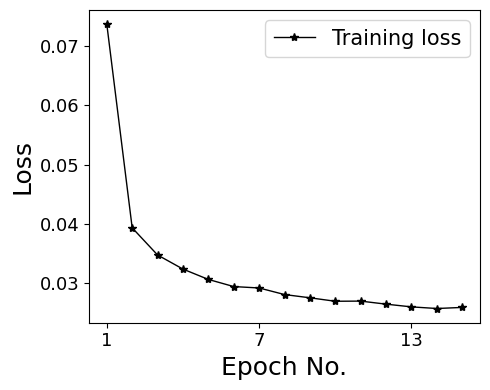

In [ ]:
N = np.arange(n_epochs) + 1

plt.figure(figsize=(5, 4))
plt.plot(N, training_loss, 'k-*', linewidth=1, label='Training loss')
plt.xlabel('Epoch No.', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.xticks(N[::6], fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=15);
plt.tight_layout()
plt.savefig('conditional_ddpm_loss.png', dpi=300)

### Reverse process output

In [ ]:
n = 4
y = torch.tensor([1, 5, 3, 8]).to(device)

print('Generating the image of:\n', y)
_, collect = ddpm.ddpm_sampling(model=model, num_samples=n, channels=1, img_size=32, labels=y)
print(len(collect))

for i in range(n):
  print(classes[y[i].detach().cpu().int()])

Generating the image of:
 tensor([1, 5, 3, 8], device='cuda:0')


1000it [00:10, 97.45it/s]

11
Trouser
Sandal
Dress
Bag


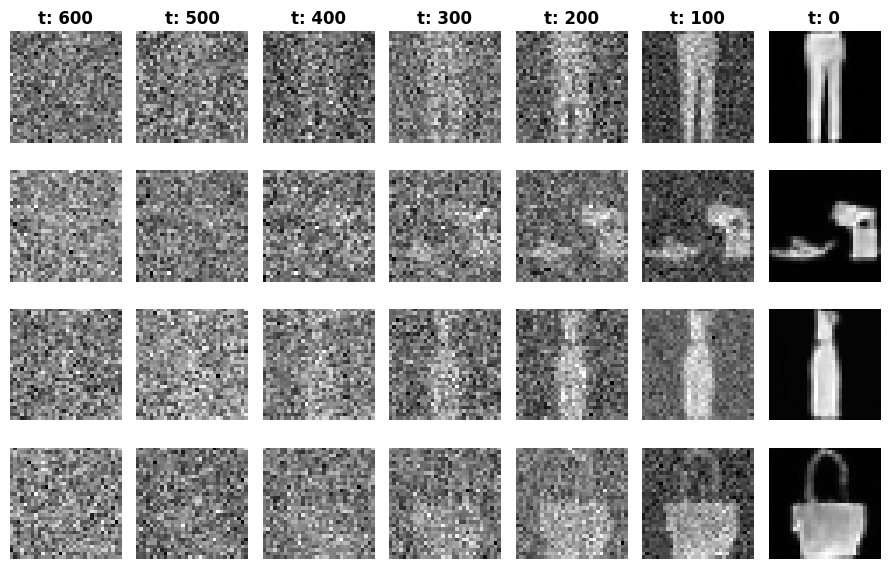

In [ ]:
step = [601,501, 401, 301, 201, 101, 1]

fig, axis = plt.subplots(nrows=n, ncols=len(step), figsize=(9, 6))
collect = collect[::-1]
collect = collect[0:len(step)]
collect = collect[::-1]

for r in range(n):
  for c in range(len(step)):
    axis[r,c].imshow(collect[c][r].detach().cpu().permute(1, 2, 0), cmap='gray')
    if(r==0):
      axis[r,c].set_title(f't: {step[c]-1}', fontweight='bold')
    axis[r,c].axis(False)

plt.tight_layout()
plt.savefig('conditional_ddpm.png', dpi=300)

1000it [00:23, 41.87it/s]


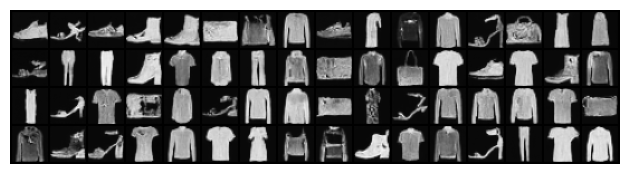

In [ ]:
Y = torch.randint(low=0, high=10, size = (64,)).to(device)
sampled_imgs, _ = ddpm.ddpm_sampling(model=model, num_samples=64, channels=1, img_size=32, labels = Y)
grid = make_grid(sampled_imgs.detach().cpu(), nrow=16, normalize=True)
plt.figure(figsize=(12, 2))
plt.imshow(grid.permute(1, 2, 0), cmap='gray')
plt.axis(False)
plt.savefig("set_of_images.png", dpi=300)

In [ ]:
y = Y.detach().cpu().numpy()
for i, k in enumerate(y):
  if i%16==0:
    print("")
  print(classes[k], end = " ")


Sneaker Sandal Sneaker Ankle boot Ankle boot Bag Shirt Pullover Sneaker Dress Pullover Shirt Sandal Bag Dress Coat 
Sandal Trouser Trouser Ankle boot Shirt Coat Trouser Coat Bag Shirt Bag T-shirt/top Sneaker T-shirt/top Ankle boot Pullover 
Dress Sandal T-shirt/top Bag Coat Sandal Pullover Coat Bag Dress Sandal Pullover Coat Coat T-shirt/top Bag 
Pullover Ankle boot Sandal T-shirt/top Shirt T-shirt/top Dress Pullover Pullover Ankle boot Shirt Pullover Sandal Trouser T-shirt/top Shirt 

### Animation

In [ ]:
n = 10
y = torch.tensor([1, 5, 3, 8, 3, 2, 9, 7, 4, 6]).to(device)

print('Generating the image of:\n', y)
_, collect = ddpm.ddpm_sampling(model=model, num_samples=n, channels=1, img_size=32, labels=y)
print(len(collect))

for i in range(n):
  print(classes[y[i].detach().cpu().int()])

Generating the image of:
 tensor([1, 5, 3, 8, 3, 2, 9, 7, 4, 6], device='cuda:0')


1000it [00:10, 91.78it/s]

11
Trouser
Sandal
Dress
Bag
Dress
Pullover
Ankle boot
Sneaker
Coat
Shirt


In [ ]:
step = [801, 701, 601,501, 401, 301, 201, 101, 1]

collect = collect[::-1]
collect = collect[0:len(step)]
collect = collect[::-1]

IMG = []
for r in range(10):
  img= collect[-1][r].detach().cpu().permute(1, 2, 0).numpy()
  img_temp.append(np.squeeze(img))
  if r==4 or r==9:
    print(len(img_temp))
    IMG.append(img_temp)
    img_temp=[]


# fig, axis = plt.subplots(nrows=n, ncols=len(step), figsize=(9, 6))
print(len(IMG[0]))
# plt.imshow(IMG, cmap='gray')

# for r in range(n):
#   for c in range(len(step)):
#     axis[r,c].imshow(collect[c][r].detach().cpu().permute(1, 2, 0), cmap='gray')
#     if(r==0):
#       axis[r,c].set_title(f't: {step[c]-1}', fontweight='bold')
#     axis[r,c].axis(False)

# plt.tight_layout()
# plt.savefig('conditional_ddpm.png', dpi=300)

5
5
5
